<a href="https://colab.research.google.com/github/yubin0727/captcha_recognition/blob/main/Captcha_model_training_with_no_line.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Fri Nov 25 02:17:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    33W /  70W |   1650MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import cv2
from glob import glob
from google.colab.patches import cv2_imshow
import numpy as np

# 데이터를 불러오고 이미지 개수를 출력
data_list = glob('sample_data/samples_no/*.png')
len_data = len(data_list)
print(len(data_list))

1575


In [ ]:
img = cv2.imread(data_list[0], cv2.IMREAD_GRAYSCALE)
cv2_imshow(img)

data_height = 24
data_width = 72
n_channel = 1

images = np.zeros((len_data, data_height, data_width, n_channel))
label = np.empty((len_data, 4), dtype = str)

characters = []

for n, path in enumerate(data_list):
  image = cv2.imread(data_list[n], cv2.IMREAD_GRAYSCALE) / 255   # 모델 학습을 위해 0 - 1 사이의 값으로 스케일링
  image = np.reshape(image, (data_height, data_width, 1)) 
  images[n, :, :, :] = image
  path = path.split('/')[2]
  path = path.split('.')[0]
  path = list(path)
  label[n] = np.array(path)
  for i in range(4):
    characters.append(path[i])

cv2_imshow(images[3] * 255)
print(label[3])
print(images.shape)

['Z' 'Q' '6' 'C']
(1575, 24, 72, 1)


In [ ]:
from string import ascii_lowercase, digits

characters = list(set(characters))
characters.sort()
#characters = list(digits) + list(ascii_lowercase)
print(characters)

['2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

# 라벨링
def char_to_num(num):
  if num in characters:
    return characters.index(num)
  return None
    

num_label = np.empty((4, len_data, len(characters)), dtype = int)
for i in range(len_data):
  targs = np.zeros((4, len(characters)))
  for j, l in enumerate(label[i]):
    ind = char_to_num(l)
    targs[j, ind] = 1
    num_label[:, i] = targs

print(num_label[3][3])

[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
import random
index_list = np.arange(len_data)
np.random.seed(42)
np.random.shuffle(index_list)
print(index_list)

# train, test split by index
for i in range(len_data):
  train_X, test_X = images[index_list[:1300]], images[index_list[1300:]]
  train_y, test_y = num_label[:,index_list[:1300]], num_label[:,index_list[1300:]]

print(len(train_X),len(test_X))
print(train_X.shape)
print(test_y.shape)
print(len(train_y[0]),len(test_y[0]))
print(train_y[3])

[1246  813 1173 ...  860 1459 1126]
1300 275
(1300, 24, 72, 1)
(4, 275, 32)
1300 275
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model

In [ ]:
from keras.backend import conv3d
def create_model(num_classes):
    img = layers.Input(shape=(data_height, data_width, 1)) # Get image as an input and process it through some Convs
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 50x13
    
    # Get flattened vector and make 5 branches from it. Each branch will predict one letter
    flat = layers.Flatten()(mp3)
    outs = []

    for _ in range(4):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_classes, activation="sigmoid")(drop)

        outs.append(res)
    # Compile model and return it
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

In [ ]:
num_classes = len(characters)
model = create_model(num_classes)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 24, 72, 1)]  0           []                               
                                                                                                  
 conv2d_36 (Conv2D)             (None, 24, 72, 16)   160         ['input_13[0][0]']               
                                                                                                  
 max_pooling2d_36 (MaxPooling2D  (None, 12, 36, 16)  0           ['conv2d_36[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_37 (Conv2D)             (None, 12, 36, 32)   4640        ['max_pooling2d_36[0][0]'] 

In [ ]:
# model.fit(train_X, [train_y[0],train_y[1],train_y[2],train_y[3],train_y[4]], epochs=10, batch_size=200, verbose=2,validation_split=0.2)
hist = model.fit(train_X, [train_y[0], train_y[1], train_y[2], train_y[3]], batch_size=32, epochs=100,verbose=1, validation_split=0.2)

Epoch 1/100
33/33 [==============================] - 2s 29ms/step - loss: 13.2408 - dense_95_loss: 2.6500 - dense_97_loss: 3.5375 - dense_99_loss: 3.5244 - dense_101_loss: 3.5290 - dense_95_accuracy: 0.1712 - dense_97_accuracy: 0.0288 - dense_99_accuracy: 0.0260 - dense_101_accuracy: 0.0202 - val_loss: 13.4630 - val_dense_95_loss: 3.0649 - val_dense_97_loss: 3.4662 - val_dense_99_loss: 3.4668 - val_dense_101_loss: 3.4652 - val_dense_95_accuracy: 0.2385 - val_dense_97_accuracy: 0.0308 - val_dense_99_accuracy: 0.0154 - val_dense_101_accuracy: 0.0269
Epoch 2/100
33/33 [==============================] - 0s 10ms/step - loss: 12.6110 - dense_95_loss: 2.2219 - dense_97_loss: 3.4620 - dense_99_loss: 3.4628 - dense_101_loss: 3.4643 - dense_95_accuracy: 0.2212 - dense_97_accuracy: 0.0365 - dense_99_accuracy: 0.0433 - dense_101_accuracy: 0.0260 - val_loss: 13.3529 - val_dense_95_loss: 2.9573 - val_dense_97_loss: 3.4659 - val_dense_99_loss: 3.4657 - val_dense_101_loss: 3.4641 - val_dense_95_accura

In [ ]:
def predict_x(img):
    img = np.reshape(img, (1, data_height, data_width, 1))
    res = np.array(model.predict(img))
    ans = np.reshape(res, (4, num_classes))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += characters[l]
    return capt#, sum(probs) / 5

In [ ]:
def print_y(y_list):
  result = ""
  for y in y_list:
    for i in range(len(y)):
      if int(y[i]) == 1:
        result += characters[i]
  return result

In [ ]:
print(predict_x(test_X[0]))
print(print_y([test_y[0][0], test_y[1][0], test_y[2][0], test_y[3][0]]))

1/1 [==============================] - 0s 170ms/step
YUN7
YUN7


In [ ]:

count = 0
for i in range(len(train_X)):
  if predict_x(train_X[i]) != print_y([train_y[0][i], train_y[1][i], train_y[2][i], train_y[3][i]]):
    count += 1

print((len(train_X)-count)/len(train_X))
print(len(train_X))

1/1 [==============================] - 0s 16ms/step
0.9784615384615385
1300


1/1 [==============================] - 0s 16ms/step
p를 b로 misclassification: 0
accuracy : 0.9942307692307693
balanced_accuracy : 0.9940575781078578
precision : 0.9928776026562431
recall : 0.9940575781078578
f1_score : 0.9933967201487754
(32, 32)


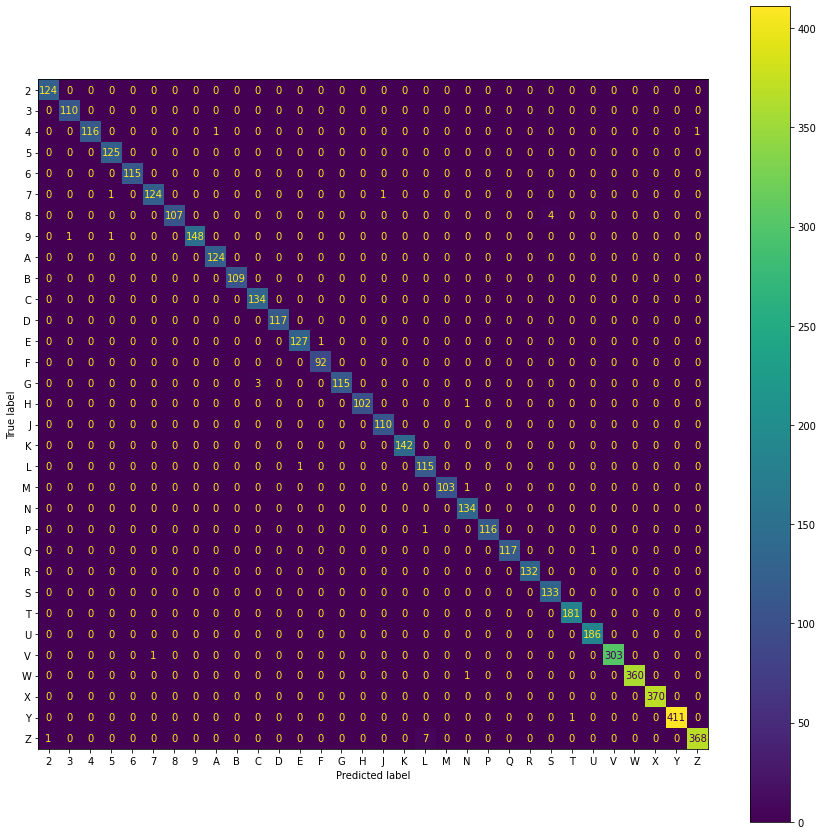

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
count = 0
y_pred = []
y_true = []
index = []

for i in range(len(train_X)):
  predictresult = predict_x(train_X[i])
  realresult = print_y([train_y[0][i], train_y[1][i], train_y[2][i], train_y[3][i]])
  for j in range(len(predictresult)):
    y_pred.append(predictresult[j])
    y_true.append(realresult[j]) 
    if (predictresult[j] == "b") and (realresult[j] == "p"):
      index.append(i)

print("p를 b로 misclassification: " + str(len(index)))

print("accuracy : " + str(metrics.accuracy_score(y_true, y_pred)) )
print("balanced_accuracy : " + str(metrics.balanced_accuracy_score(y_true, y_pred)))
print("precision : " + str(metrics.precision_score(y_true, y_pred,average="macro")))
print("recall : " + str(metrics.recall_score(y_true, y_pred,average="macro")))
print("f1_score : " + str(metrics.f1_score(y_true, y_pred,average="macro")))

conf_mat = metrics.confusion_matrix(y_true, y_pred) 
print(conf_mat.shape)
conf_dis = metrics.ConfusionMatrixDisplay(conf_mat, display_labels=characters)
fig, ax = plt.subplots(figsize=(15, 15))
conf_dis.plot(ax = ax)

# 선 없애기


In [ ]:
# p를 b로 misclassification한 경우
for i in range(len(index)):
  cv2_imshow(train_X[index[i]] * 255)

1/1 [==============================] - 0s 15ms/step
accuracy : 0.9763636363636363
balanced_accuracy : 0.9706612448522423
precision : 0.971836272219835
recall : 0.9706612448522423
f1_score : 0.9705056283852704
(32, 32)


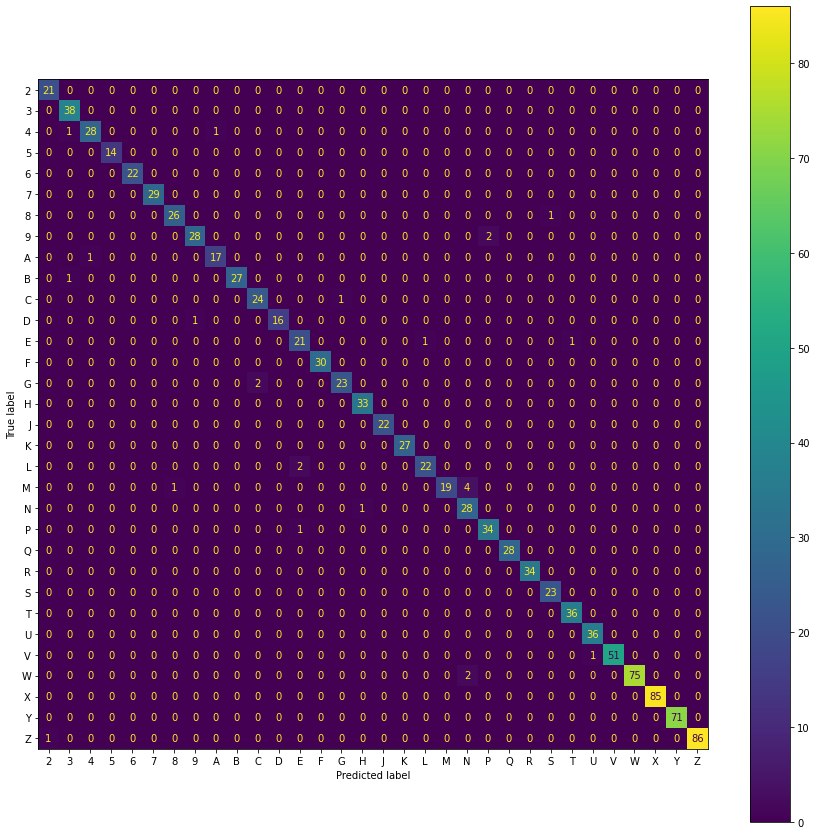

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
count = 0
y_pred.clear()
y_true.clear()
index = []

for i in range(len(test_X)):
  predictresult = predict_x(test_X[i])
  realresult = print_y([test_y[0][i], test_y[1][i], test_y[2][i], test_y[3][i]])
  for j in range(len(predictresult)):
    y_pred.append(predictresult[j])
    y_true.append(realresult[j]) 
print("accuracy : " + str(metrics.accuracy_score(y_true, y_pred)) )
print("balanced_accuracy : " + str(metrics.balanced_accuracy_score(y_true, y_pred)))
print("precision : " + str(metrics.precision_score(y_true, y_pred,average="macro")))
print("recall : " + str(metrics.recall_score(y_true, y_pred,average="macro")))
print("f1_score : " + str(metrics.f1_score(y_true, y_pred,average="macro")))

conf_mat = metrics.confusion_matrix(y_true, y_pred) 
print(conf_mat.shape)
conf_dis = metrics.ConfusionMatrixDisplay(conf_mat, display_labels=characters)
fig, ax = plt.subplots(figsize=(15, 15))
conf_dis.plot(ax = ax)